In [309]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score,f1_score

from imblearn.over_sampling import SMOTE

In [2]:
company = pd.read_csv(r'F:\01_Dataset\04 Tabular\05 Company Bankrupcy Prediction\data.csv')
company.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [3]:
company_min = company.describe().transpose()['min']
company_min.value_counts()

0.0    95
1.0     1
Name: min, dtype: int64

In [4]:
company_min = company.describe().transpose()['max']
company_min.value_counts()

1.000000e+00    72
9.990000e+09     4
1.000000e+10     3
8.320000e+09     1
9.540000e+09     1
9.910000e+09     1
9.650000e+09     1
8.820000e+09     1
9.570000e+09     1
8.810000e+09     1
9.730000e+09     1
9.740000e+09     1
9.940000e+09     1
9.230000e+09     1
2.750000e+09     1
9.330000e+09     1
3.020000e+09     1
9.900000e+08     1
9.980000e+09     1
9.820000e+09     1
Name: max, dtype: int64

## PART I : FEATURE SELECTION

In [5]:
a = company.isnull().sum()
a.value_counts()

0    96
dtype: int64

In [6]:
company_corr = pd.DataFrame(company.corr().unstack(level=1))
company_corr = company_corr.reset_index()
company_corr.columns = ['main_feature','correlated feature','correlation_score']
company_corr = company_corr[company_corr['main_feature'] != company_corr['correlated feature']]
company_corr = company_corr.sort_values(by='correlation_score',ascending=False)
company_corr

,main_feature,correlated feature,correlation_score
7456,Current Liability to Liability,Current Liabilities/Liability,1.0
6414,Current Liabilities/Equity,Current Liability to Equity,1.0
6221,Current Liabilities/Liability,Current Liability to Liability,1.0
7554,Current Liability to Equity,Current Liabilities/Equity,1.0
8548,Gross Profit to Sales,Operating Gross Margin,1.0
...,...,...,...
9115,Net Income Flag,Liability to Equity,NaN
9116,Net Income Flag,Degree of Financial Leverage (DFL),NaN
9117,Net Income Flag,Interest Coverage Ratio (Interest expense to ...,NaN
9119,Net Income Flag,Equity to Liability,NaN


## Obeservation
the above table shoed that high correlation score is the redundancy feature such as Current Liability to Liability and Current Liabilities/Liability is the repeative feature which is kept in different name of feature.

In [7]:
#Delete Feature - "Net Income Flag" - they are one in every company.
company = company.drop(' Net Income Flag',axis=1)

#### Correlation-based feature selection

In [8]:
#Delete the feature more than 0.9
corr = company.corr()
columns = np.full((corr.shape[0],),True,dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1,corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
company_new = company[company.columns[columns]]
len(company_new.columns)

77

#### Model-based Feature Selection

In [9]:
X = company_new.drop('Bankrupt?',axis=1)
y = company_new['Bankrupt?']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=41)

In [10]:
n_features = [5,10,15,20,25,30,35,40,45]
for i in n_features:
    rfe = RFE(RandomForestClassifier(n_estimators=100,random_state=41),n_features_to_select=i)
    rfe.fit(X_train,y_train)
    mask = rfe.get_support()

    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)
    score = RandomForestClassifier().fit(X_train_rfe,y_train).score(X_test_rfe,y_test)
    print("Test score: {:.3f}".format(score), " number of features: {}".format(i))

Test score: 0.966  number of features: 5
Test score: 0.968  number of features: 10
Test score: 0.968  number of features: 15
Test score: 0.970  number of features: 20
Test score: 0.970  number of features: 25
Test score: 0.971  number of features: 30
Test score: 0.968  number of features: 35
Test score: 0.970  number of features: 40
Test score: 0.970  number of features: 45


the number of optimal feature to reach the highest accuracy is "30".

In [19]:
rfe = RFE(RandomForestClassifier(n_estimators=100,random_state=41),n_features_to_select=30)
rfe.fit(X_train,y_train)
mask =rfe.get_support()
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)
feature = pd.DataFrame({'features':list(company_new.iloc[:,1:].keys()),'select':list(mask)})

In [21]:
selected_col = list(feature[feature['select'] == True]['features'])
selected_col.append('Bankrupt?')
company_rfe = company_new[selected_col]
company_rfe.head()

,ROA(C) before interest and depreciation before interest,Non-industry income and expenditure/revenue,Interest-bearing debt interest rate,Net Value Per Share (B),Persistent EPS in the Last Four Seasons,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,...,Inventory/Working Capital,Working Capital/Equity,Total income/Total expense,Total assets to GNP price,No-credit Interval,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt?
0,0.370594,0.302646,0.000725,0.147950,0.169141,0.000327,0.263100,0.001208,0.629951,0.021266,...,0.276920,0.721275,0.002022,0.009219,0.622879,0.827890,0.026601,0.564050,0.016469,1
1,0.464291,0.303556,0.000647,0.182251,0.208944,0.000443,0.264516,0.004039,0.635172,0.012502,...,0.289642,0.731975,0.002226,0.008323,0.623652,0.839969,0.264577,0.570175,0.020794,1
2,0.426071,0.302035,0.000790,0.177911,0.180581,0.000396,0.264184,0.005348,0.629631,0.021248,...,0.277456,0.742729,0.002060,0.040003,0.623841,0.836774,0.026555,0.563706,0.016474,1
3,0.399844,0.303350,0.000449,0.154187,0.193722,0.000382,0.263371,0.002896,0.630228,0.009572,...,0.276580,0.729825,0.001831,0.003252,0.622929,0.834697,0.026697,0.564663,0.023982,1
4,0.465022,0.303475,0.000686,0.167502,0.212537,0.000439,0.265218,0.003727,0.636055,0.005150,...,0.287913,0.732000,0.002224,0.003878,0.623521,0.839973,0.024752,0.575617,0.035490,1


## PART II : EXPLORATORY DATA ANALYSIS

In [29]:
company_df = company_rfe.copy()
company_df['Bankrupt?'] = company_df['Bankrupt?'].replace({1:'Yes',0:'No'})
company_df.head()

,ROA(C) before interest and depreciation before interest,Non-industry income and expenditure/revenue,Interest-bearing debt interest rate,Net Value Per Share (B),Persistent EPS in the Last Four Seasons,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,...,Inventory/Working Capital,Working Capital/Equity,Total income/Total expense,Total assets to GNP price,No-credit Interval,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt?
0,0.370594,0.302646,0.000725,0.147950,0.169141,0.000327,0.263100,0.001208,0.629951,0.021266,...,0.276920,0.721275,0.002022,0.009219,0.622879,0.827890,0.026601,0.564050,0.016469,Yes
1,0.464291,0.303556,0.000647,0.182251,0.208944,0.000443,0.264516,0.004039,0.635172,0.012502,...,0.289642,0.731975,0.002226,0.008323,0.623652,0.839969,0.264577,0.570175,0.020794,Yes
2,0.426071,0.302035,0.000790,0.177911,0.180581,0.000396,0.264184,0.005348,0.629631,0.021248,...,0.277456,0.742729,0.002060,0.040003,0.623841,0.836774,0.026555,0.563706,0.016474,Yes
3,0.399844,0.303350,0.000449,0.154187,0.193722,0.000382,0.263371,0.002896,0.630228,0.009572,...,0.276580,0.729825,0.001831,0.003252,0.622929,0.834697,0.026697,0.564663,0.023982,Yes
4,0.465022,0.303475,0.000686,0.167502,0.212537,0.000439,0.265218,0.003727,0.636055,0.005150,...,0.287913,0.732000,0.002224,0.003878,0.623521,0.839973,0.024752,0.575617,0.035490,Yes


In [231]:
def visualize(columns_vis,quan):
    j = 0
    k = 0
    fig, axes = plt.subplots(15,2,figsize=(15,100))
    for i in range(len(columns_vis)):
        h = company_df[company_df[columns_vis[i]] < company_df[columns_vis[i]].quantile(quan[i])]
        if i % 2 == 0:
            sns.boxplot(ax=axes[j][0],x='Bankrupt?',y=columns_vis[i],data=h)
            axes[j][0].set_title(columns_vis[i] + ' with ' + str(quan[i]) + ' Quantile')
            j = j +1
        if i % 2 == 1:
            sns.boxplot(ax=axes[k][1],x='Bankrupt?',y=columns_vis[i],data=h)
            axes[k][1].set_title(columns_vis[i] + ' with ' + str(quan[i]) + ' Quantile')
            k = k +1

columns_vis = company_df.columns[:-1]
quan = [0.75,0.001,0.75,0.75,0.75,
       0.75,0.0007,0.75,0.00295,0.75,
        0.75,0.01,0.75,0.75,0.75,
       0.75,0.01,0.75,0.75,0.75,
       0.75,0.003,0.002,0.75,0.75,
        0.005,0.005,0.01,0.007,0.75]

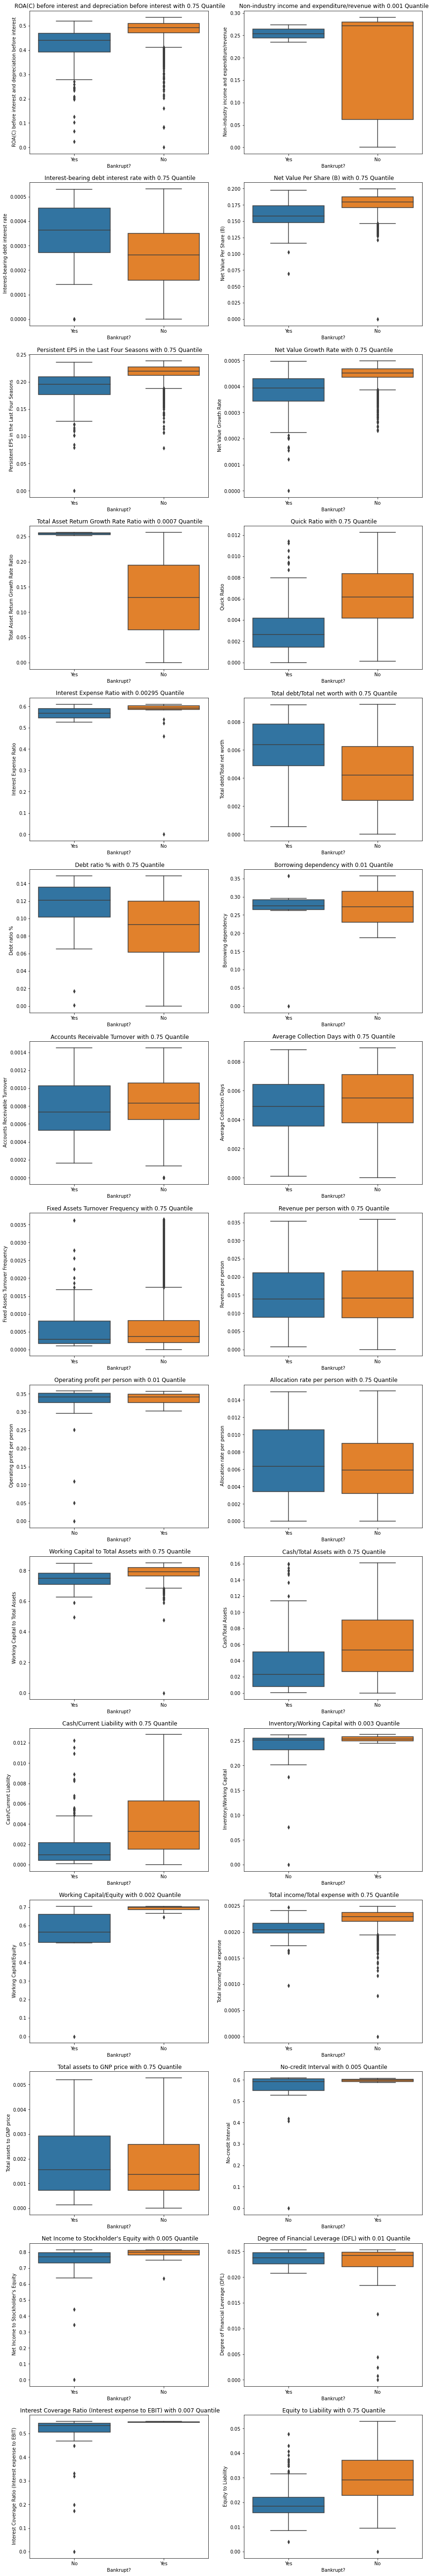

In [232]:
visualize(columns_vis,quan)

## PART III Model Development
1. Random Forest
2. Gradient Boosting
3. AdaBoost

In [237]:
company_df['Bankrupt?'] = company_df['Bankrupt?'].replace({'Yes':1,'No':2})
company_df.head()

,ROA(C) before interest and depreciation before interest,Non-industry income and expenditure/revenue,Interest-bearing debt interest rate,Net Value Per Share (B),Persistent EPS in the Last Four Seasons,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,...,Inventory/Working Capital,Working Capital/Equity,Total income/Total expense,Total assets to GNP price,No-credit Interval,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt?
0,0.370594,0.302646,0.000725,0.147950,0.169141,0.000327,0.263100,0.001208,0.629951,0.021266,...,0.276920,0.721275,0.002022,0.009219,0.622879,0.827890,0.026601,0.564050,0.016469,1
1,0.464291,0.303556,0.000647,0.182251,0.208944,0.000443,0.264516,0.004039,0.635172,0.012502,...,0.289642,0.731975,0.002226,0.008323,0.623652,0.839969,0.264577,0.570175,0.020794,1
2,0.426071,0.302035,0.000790,0.177911,0.180581,0.000396,0.264184,0.005348,0.629631,0.021248,...,0.277456,0.742729,0.002060,0.040003,0.623841,0.836774,0.026555,0.563706,0.016474,1
3,0.399844,0.303350,0.000449,0.154187,0.193722,0.000382,0.263371,0.002896,0.630228,0.009572,...,0.276580,0.729825,0.001831,0.003252,0.622929,0.834697,0.026697,0.564663,0.023982,1
4,0.465022,0.303475,0.000686,0.167502,0.212537,0.000439,0.265218,0.003727,0.636055,0.005150,...,0.287913,0.732000,0.002224,0.003878,0.623521,0.839973,0.024752,0.575617,0.035490,1


In [316]:
X = company_df.drop('Bankrupt?',axis=1)
y = company_df['Bankrupt?']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

#### RANDOM FOREST

In [317]:
rf = RandomForestClassifier(n_estimators=100,random_state=41)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=41)

In [318]:
rf_pred = rf.predict(X_test)
rf_pred_prob = rf.predict_proba(np.array(X_test.values))[:,1]
print(classification_report(y_test,rf_pred))
print("ROC AUC SCORE :",format(roc_auc_score(y_test,rf_pred_prob)))

              precision    recall  f1-score   support

           1       0.48      0.20      0.29        64
           2       0.97      0.99      0.98      1982

    accuracy                           0.97      2046
   macro avg       0.73      0.60      0.63      2046
weighted avg       0.96      0.97      0.96      2046

ROC AUC SCORE : 0.9216779137235116


C:\Users\warintorn.nawong13\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### GRADIENT BOOSTING

In [319]:
gb = GradientBoostingClassifier(n_estimators=100,random_state=41)
gb.fit(X_train,y_train)

GradientBoostingClassifier(random_state=41)

In [320]:
gb_pred = gb.predict(X_test)
gb_pred_prob = gb.predict_proba(np.array(X_test.values))[:,1]
print(classification_report(y_test,gb_pred))
print("ROC AUC SCORE :",format(roc_auc_score(y_test,gb_pred_prob)))

              precision    recall  f1-score   support

           1       0.42      0.25      0.31        64
           2       0.98      0.99      0.98      1982

    accuracy                           0.97      2046
   macro avg       0.70      0.62      0.65      2046
weighted avg       0.96      0.97      0.96      2046

ROC AUC SCORE : 0.9245869071644803


C:\Users\warintorn.nawong13\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


## ADABOOST

In [270]:
ada = AdaBoostClassifier(n_estimators=100,random_state=41)
ada.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=100, random_state=41)

In [272]:
ada_pred = ada.predict(X_test)
ada_pred_prob = ada.predict_proba(np.array(X_test.values))[:,1]
print(classification_report(y_test,ada_pred))
print("ROC AUC SCORE :",format(roc_auc_score(y_test,ada_pred_prob)))

              precision    recall  f1-score   support

           1       0.60      0.37      0.45        68
           2       0.98      0.99      0.98      1978

    accuracy                           0.97      2046
   macro avg       0.79      0.68      0.72      2046
weighted avg       0.97      0.97      0.97      2046

ROC AUC SCORE : 0.9363364658300124


C:\Users\warintorn.nawong13\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


## PART IV : OVERSAMPLING

In [285]:
X = company_df.drop('Bankrupt?',axis=1)
y = company_df['Bankrupt?']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
y_train.value_counts()

2    4630
1     143
Name: Bankrupt?, dtype: int64

According to impbalance dataset, we would generate the dataset of minority class/label to reach the majorority class to test whether it help precision and recall of model.

In [286]:
sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X_train,y_train)
y_resampled.value_counts()

2    4630
1    4630
Name: Bankrupt?, dtype: int64

### RANDOM FOREST + OVERSAMPLING

In [288]:
rf = RandomForestClassifier(n_estimators=100,random_state=41)
rf.fit(X_resampled,y_resampled)

RandomForestClassifier(random_state=41)

In [291]:
rf_pred_resampled = rf.predict(X_test)
rf_pred_prob_resampled = rf.predict_proba(np.array(X_test.values))[:,1]
print(classification_report(y_test,rf_pred_resampled))
print("ROC AUC SCORE :",format(roc_auc_score(y_test,rf_pred_prob_resampled)))

              precision    recall  f1-score   support

           1       0.37      0.58      0.45        77
           2       0.98      0.96      0.97      1969

    accuracy                           0.95      2046
   macro avg       0.68      0.77      0.71      2046
weighted avg       0.96      0.95      0.95      2046

ROC AUC SCORE : 0.9272555783475032


C:\Users\warintorn.nawong13\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### GRADIENT BOOSTING + OVERSAMPLING

In [292]:
gb = GradientBoostingClassifier(n_estimators=100,random_state=41)
gb.fit(X_train,y_train)

GradientBoostingClassifier(random_state=41)

In [295]:
gb_pred_resampled = gb.predict(X_test)
gb_pred_prob_resampled = gb.predict_proba(np.array(X_test.values))[:,1]
print(classification_report(y_test,gb_pred_resampled))
print("ROC AUC SCORE :",format(roc_auc_score(y_test,gb_pred_prob_resampled)))

              precision    recall  f1-score   support

           1       0.57      0.30      0.39        77
           2       0.97      0.99      0.98      1969

    accuracy                           0.97      2046
   macro avg       0.77      0.65      0.69      2046
weighted avg       0.96      0.97      0.96      2046

ROC AUC SCORE : 0.9316615329820002


C:\Users\warintorn.nawong13\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


## ADABOOST + OVERSAMPLING

In [296]:
ada = AdaBoostClassifier(n_estimators=100,random_state=41)
ada.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=100, random_state=41)

In [297]:
ada_pred_resampled = ada.predict(X_test)
ada_pred_prob_resampled = ada.predict_proba(np.array(X_test.values))[:,1]
print(classification_report(y_test,ada_pred_resampled))
print("ROC AUC SCORE :",format(roc_auc_score(y_test,ada_pred_prob_resampled)))

              precision    recall  f1-score   support

           1       0.46      0.29      0.35        77
           2       0.97      0.99      0.98      1969

    accuracy                           0.96      2046
   macro avg       0.72      0.64      0.67      2046
weighted avg       0.95      0.96      0.96      2046

ROC AUC SCORE : 0.9260023876580505


C:\Users\warintorn.nawong13\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


## PART V : HYPERPARAMETER TUNING

#### RANDOM FOREST + OVERSAMPLING + FINETUNING with "ROC_AUC_SCORE"

In [303]:
rf_param_grid = {'criterion' : ['gini','entropy'],
                 'n_estimators': [80,100,200],
                 'max_depth': [1,2,4]}

rf_grid = GridSearchCV(RandomForestClassifier(),param_grid = rf_param_grid,cv=4,scoring='roc_auc')
rf_grid.fit(X_resampled,y_resampled)
print(rf_grid.best_estimator_)

RandomForestClassifier(max_depth=4, n_estimators=200)


In [304]:
best_rf = rf_grid.best_estimator_.fit(X_resampled, y_resampled)
pred_df = best_rf.predict(X_test)
prob_rf = best_rf.predict_proba(np.array(X_test.values))[:,1]

print(classification_report(y_test,pred_df))
print("ROC AUC SCORE :",format(roc_auc_score(y_test,prob_rf )))

              precision    recall  f1-score   support

           1       0.23      0.77      0.35        77
           2       0.99      0.90      0.94      1969

    accuracy                           0.89      2046
   macro avg       0.61      0.83      0.65      2046
weighted avg       0.96      0.89      0.92      2046

ROC AUC SCORE : 0.9237334529360939


C:\Users\warintorn.nawong13\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


#### GradientBoosting + OVERSAMPLING + FINETUNING with "ROC_AUC_SCORE"

In [305]:
## Fine Tune Model + Oversampling Technique
gb_param_grid = {'loss' : ['deviance'],
                 'n_estimators': [10,100,200,500],
                 'max_depth': [1,2,4,5]}
gb_grid = GridSearchCV(GradientBoostingClassifier(),param_grid = gb_param_grid,cv=4,scoring='roc_auc')
gb_grid.fit(X_resampled,y_resampled)
print(gb_grid.best_estimator_)

GradientBoostingClassifier(max_depth=5, n_estimators=500)


In [306]:
best_gb = gb_grid.best_estimator_.fit(X_resampled, y_resampled)
pred_gb = best_gb.predict(X_test)
prob_gb = best_gb.predict_proba(np.array(X_test.values))[:,1]

print(classification_report(y_test,pred_gb))
print("ROC AUC SCORE :",format(roc_auc_score(y_test,prob_gb )))

              precision    recall  f1-score   support

           1       0.39      0.48      0.43        77
           2       0.98      0.97      0.97      1969

    accuracy                           0.95      2046
   macro avg       0.68      0.73      0.70      2046
weighted avg       0.96      0.95      0.95      2046

ROC AUC SCORE : 0.9262332385745288


C:\Users\warintorn.nawong13\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


#### ADABoost + OVERSAMPLING + FINETUNING with "ROC_AUC_SCORE"

In [307]:
ABC_param_grid = {"n_estimators" :[10,50,100],
                  "learning_rate":  [0.001, 0.01]}
ada_grid = GridSearchCV(AdaBoostClassifier(),param_grid = ABC_param_grid,cv=4,scoring='roc_auc')
ada_grid.fit(X_resampled,y_resampled)
print(ada_grid.best_estimator_)

AdaBoostClassifier(learning_rate=0.01, n_estimators=100)


In [308]:
best_ada = ada_grid.best_estimator_.fit(X_resampled, y_resampled)
pred_ada = best_ada.predict(X_test)
prob_ada = best_ada.predict_proba(np.array(X_test.values))[:,1]

print(classification_report(y_test,pred_ada))
print("ROC AUC SCORE :",format(roc_auc_score(y_test,prob_ada)))

              precision    recall  f1-score   support

           1       0.22      0.68      0.33        77
           2       0.99      0.91      0.94      1969

    accuracy                           0.90      2046
   macro avg       0.60      0.79      0.64      2046
weighted avg       0.96      0.90      0.92      2046

ROC AUC SCORE : 0.9003977231503895


C:\Users\warintorn.nawong13\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


#### RANDOM FOREST + OVERSAMPLING + FINETUNING with "F1_SCORE"

In [321]:
rf_param_grid = {'criterion' : ['gini','entropy'],
                 'n_estimators': [80,100,200],
                 'max_depth': [1,2,4]}

rf_grid = GridSearchCV(RandomForestClassifier(),param_grid = rf_param_grid,cv=4,scoring='f1')
rf_grid.fit(X_resampled,y_resampled)
print(rf_grid.best_estimator_)

RandomForestClassifier(max_depth=4)


In [322]:
best_rf = rf_grid.best_estimator_.fit(X_resampled, y_resampled)
pred_df = best_rf.predict(X_test)
prob_rf = best_rf.predict_proba(np.array(X_test.values))[:,1]

print(classification_report(y_test,pred_df))
print("ROC AUC SCORE :",format(roc_auc_score(y_test,prob_rf )))

              precision    recall  f1-score   support

           1       0.20      0.86      0.32        64
           2       0.99      0.89      0.94      1982

    accuracy                           0.89      2046
   macro avg       0.60      0.87      0.63      2046
weighted avg       0.97      0.89      0.92      2046

ROC AUC SCORE : 0.9418792570635721


C:\Users\warintorn.nawong13\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


#### GradientBoosting + OVERSAMPLING + FINETUNING with "F1_SCORE"

In [324]:
## Fine Tune Model + Oversampling Technique
gb_param_grid = {'loss' : ['deviance'],
                 'n_estimators': [10,100,200,500],
                 'max_depth': [1,2,4,5]}
gb_grid = GridSearchCV(GradientBoostingClassifier(),param_grid = gb_param_grid,cv=4,scoring='f1')
gb_grid.fit(X_resampled,y_resampled)
print(gb_grid.best_estimator_)

GradientBoostingClassifier(max_depth=5, n_estimators=500)


In [325]:
best_gb = gb_grid.best_estimator_.fit(X_resampled, y_resampled)
pred_gb = best_gb.predict(X_test)
prob_gb = best_gb.predict_proba(np.array(X_test.values))[:,1]

print(classification_report(y_test,pred_gb))
print("ROC AUC SCORE :",format(roc_auc_score(y_test,prob_gb )))

              precision    recall  f1-score   support

           1       0.76      0.83      0.79        64
           2       0.99      0.99      0.99      1982

    accuracy                           0.99      2046
   macro avg       0.88      0.91      0.89      2046
weighted avg       0.99      0.99      0.99      2046

ROC AUC SCORE : 0.9800469853683149


C:\Users\warintorn.nawong13\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


#### ADABoost + OVERSAMPLING + FINETUNING with "F1_SCORE"

In [326]:
ABC_param_grid = {"n_estimators" :[10,50,100],
                  "learning_rate":  [0.001, 0.01]}
ada_grid = GridSearchCV(AdaBoostClassifier(),param_grid = ABC_param_grid,cv=4,scoring='f1')
ada_grid.fit(X_resampled,y_resampled)
print(ada_grid.best_estimator_)

AdaBoostClassifier(learning_rate=0.01, n_estimators=100)


In [327]:
best_ada = ada_grid.best_estimator_.fit(X_resampled, y_resampled)
pred_ada = best_ada.predict(X_test)
prob_ada = best_ada.predict_proba(np.array(X_test.values))[:,1]

print(classification_report(y_test,pred_ada))
print("ROC AUC SCORE :",format(roc_auc_score(y_test,prob_ada)))

              precision    recall  f1-score   support

           1       0.18      0.78      0.30        64
           2       0.99      0.89      0.94      1982

    accuracy                           0.89      2046
   macro avg       0.59      0.83      0.62      2046
weighted avg       0.97      0.89      0.92      2046

ROC AUC SCORE : 0.9254895623107972


C:\Users\warintorn.nawong13\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
